## Collect Map Data

### Import and Process Data

In [79]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import ast

data = []

# Manual offset control for how far a bot was observed to rotate each time
# and if the bot moved away from the point it started at before starting measurements
# Keys are (start_x, start_y, run number), values determined from video recordings
offsets = {
    (5,-3, 1): {
        "angle": 45 * np.pi / 180,
        "distance": (0,0),
    },
    (5,-3, 2): {
        "angle": (360/16) * np.pi / 180,
        "distance": (0,0)
    },
    (-3,-2, 1): {
        "angle": (360/19) * np.pi / 180,
        "distance": (0,-1)
    },
    (0,3, 1): {
        "angle": (360/21) * np.pi / 180,
        "distance": (0, -0.5)
    },
    (5,3, 1): {
        "angle": (360/20) * np.pi / 180,
        "distance": (0, 0.25)
    },
    (0,0, 1): {
        "angle": (360/24) * np.pi / 180,
        "distance": (0,0)
    },
    (0,0,2): {
        "angle": (360/21) * np.pi / 180,
        "distance": (0,0)
    }
}

# Reads all the files and makes a nice dictionary structure
for filename in glob.glob("data/*.txt"):
    # There's one file named "tests.txt" that neither follows convention nor
    # reflects the lab floor, so skip it
    if filename[5] == 't': continue 
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        new_data = dict()
        start = filename[5:-4].split("_")
        start_point = (int(start[0]), int(start[1]))
        version = int(start[2])
        new_data["start"] = start_point
        for line in f.readlines():
            if line.startswith("polar_points"):
                new_data["polar_points"] = ast.literal_eval(line[len("polar_points = "):])
            new_data["offset_polar_points"] = []
        version_key = (start_point[0], start_point[1], version)
        if version_key in offsets.keys():
            for i, (r,_) in enumerate(new_data["polar_points"]):    
                new_data["offset_polar_points"].append((
                    r, 
                    i * offsets[version_key]["angle"], 
                    offsets[version_key]["distance"]
                ))
        data.append(new_data)

# Convert to cartesan points and add offsets
xy_points = []
for d in data:
    (start_x, start_y) = d["start"]
    polar_points = d["offset_polar_points"]
    foot_to_mm = 304.8 # 304.8 in 1 foot (i.e. 1 lab tile side length)
    theta_offset = np.pi/2
    for (r,theta, dist) in polar_points:
        # Bot angles are measured clockwise-positive (while normal math measures the other way)
        # and bot angles start from 0 but are pi/2 in conventional math
        xy_points.append((
            r*np.cos(-1*theta + theta_offset) + start_x * foot_to_mm + dist[0] * foot_to_mm, 
            r*np.sin(-1*theta + theta_offset) + start_y * foot_to_mm + dist[1] * foot_to_mm
            ))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Draw Map

### Draw Observed Walls Map
The observed wall map is found with me looking at the videos and determining approximate coordinates, regardless of what the sensor data says.
This assumes all walls and obstacle boundaries are in the middle of tiles. Although they aren't actually that way in the lab,
it's helpful as a starting point.

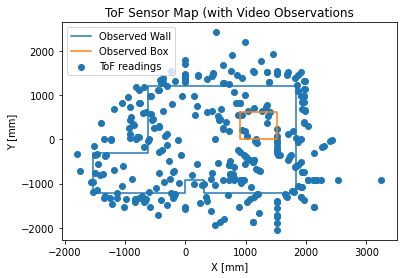

In [80]:
f = 304.8 # Conversion factor: 1 foot = f mm
wall_points = [
  (-5, -4),
  (0, -4),
  (0, -3),
  (1, -3),
  (1, -4),
  (6, -4),
  (6, 4),
  (-2, 4),
  (-2,-1),
  (-5,-1),
  (-5,-4)
]
plt.plot([x[0]*f for x in wall_points], [x[1]*f for x in wall_points], label="Observed Wall")
box_points = [
  (3,2),
  (5,2),
  (5,0),
  (3,0),
  (3,2)
]
plt.plot([x[0]*f for x in box_points], [x[1]*f for x in box_points], label="Observed Box")

points_x = [x[0] for x in xy_points]
points_y = [x[1] for x in xy_points]
plt.scatter(points_x, points_y, label="ToF readings")
plt.title("ToF Sensor Map (with Video Observations")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.legend()

### Inferred Map
The inferred map comes from me tweaking the points of the observed map to fit the data.
This is likely more accurate given that the observed map assumes walls are in the center of each tile (and they aren't in the lab)

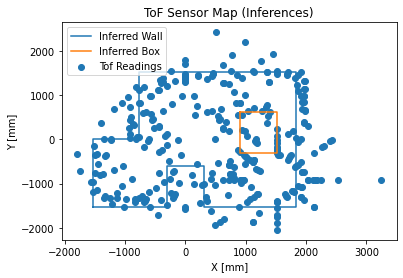

In [81]:
wall_points = [
  (-5, -5),
  (-1, -5),
  (-1, -2),
  (1, -2),
  (1, -5),
  (6, -5),
  (6, 5),
  (-2.5, 5),
  (-2.5,-0),
  (-5,-0),
  (-5,-5)
]
plt.plot([x[0]*f for x in wall_points], [x[1]*f for x in wall_points], label="Inferred Wall")
box_points = [
  (3,2),
  (5,2),
  (5,-1),
  (3,-1),
  (3,2)
]
plt.plot([x[0]*f for x in box_points], [x[1]*f for x in box_points], label="Inferred Box")

points_x = [x[0] for x in xy_points]
points_y = [x[1] for x in xy_points]
plt.scatter(points_x, points_y, label="Tof Readings")
plt.title("ToF Sensor Map (Inferences)")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.legend()

### Combined Map
This is the observed and inferred map overlaid onto each other to see the differences.
Although there are spots where the sensor looks like it's blocking another area, it makes sense because the sensor's noise
increases with distance read (so long regions of open space are more noisy, and small openings are more likely
to have their surrounding walls sensed instead of the open space)

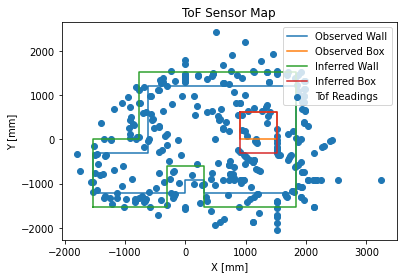

In [82]:
f = 304.8 # Conversion factor: 1 foot = f mm
wall_points = [
  (-5, -4),
  (0, -4),
  (0, -3),
  (1, -3),
  (1, -4),
  (6, -4),
  (6, 4),
  (-2, 4),
  (-2,-1),
  (-5,-1),
  (-5,-4)
]
plt.plot([x[0]*f for x in wall_points], [x[1]*f for x in wall_points], label="Observed Wall")
box_points = [
  (3,2),
  (5,2),
  (5,0),
  (3,0),
  (3,2)
]
plt.plot([x[0]*f for x in box_points], [x[1]*f for x in box_points], label="Observed Box")
wall_points = [
  (-5, -5),
  (-1, -5),
  (-1, -2),
  (1, -2),
  (1, -5),
  (6, -5),
  (6, 5),
  (-2.5, 5),
  (-2.5,-0),
  (-5,-0),
  (-5,-5)
]
plt.plot([x[0]*f for x in wall_points], [x[1]*f for x in wall_points], label="Inferred Wall")
box_points = [
  (3,2),
  (5,2),
  (5,-1),
  (3,-1),
  (3,2)
]
plt.plot([x[0]*f for x in box_points], [x[1]*f for x in box_points], label="Inferred Box")

points_x = [x[0] for x in xy_points]
points_y = [x[1] for x in xy_points]
plt.scatter(points_x, points_y, label="Tof Readings")
plt.title("ToF Sensor Map")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.legend()